# Latent MNIST data experiments
This file contains experiments for the latent MNIST data set. 

In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
import torch.distributions as dist
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
from GANmodel import *
from lineardatatools import p_y_zt_from_true_dist, linear_binary_ty_pydot
from matplotlib.lines import Line2D
from imagedata import *
from imagedatatools import *
from plot_functions import *
%load_ext autoreload
%autoreload 2

In [2]:
netG = Generator(3)
netD = Discriminator()
netG.load_state_dict(torch.load("./GANmodels/3dGenerator"))
netD.load_state_dict(torch.load("./GANmodels/3dDiscriminator"))

<All keys matched successfully>

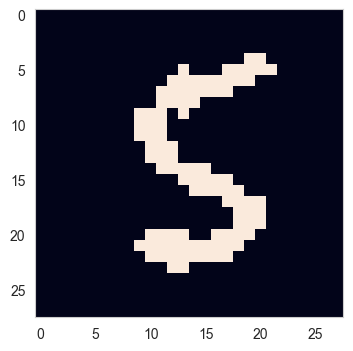

In [3]:
#Example image from the data generating distribution
z = torch.randn(1,3)[:,:,None,None]
im =((1+netG(z))/2).squeeze()
fig, ax = plt.subplots(1,1, figsize=(4,4))
plt.imshow(dist.Bernoulli(im).sample())
plt.grid(False)

# Generate data for loss scaling tests

In [4]:
main_folder = "imagedata"
sub_folder_data = "samplesize100000"

data_labels = ["data100000"]

generator = netG
c_x = np.array([1])
s_x = np.array([1])
t_a = np.array([1])
t_b = np.array([0.5])
y_a0 = np.array([2])
y_b0 = np.array([-0.5])
y_a1 = np.array([2])
y_b1 = np.array([0.5])
param_times = 1
gen_zdim=3
dataparameters = [[100000, gen_zdim, generator, t_a, t_b, y_a0, y_b0, y_a1, y_b1, c_x, s_x]]

In [5]:
create_dfs_datasets(generate_image_data, dataparameters, param_times, repeat=True, main_folder=main_folder,
                    sub_folder=sub_folder_data, labels=data_labels)

Step  0


({'data100000': {0:              z0        z1        z2        x0    t         y
   0     -0.033588 -0.056642 -0.032322  2.496197  1.0  1.092581
   1     -0.153361 -1.836679  0.670796 -0.384910  0.0 -0.873604
   2      0.331998 -0.223278 -1.932001  0.888722  1.0  1.218269
   3     -0.103416 -0.003162 -1.015926  1.221512  1.0 -0.985543
   4     -0.790482  3.427965 -0.962994 -1.103791  1.0 -0.549818
   ...         ...       ...       ...       ...  ...       ...
   99995  1.129985  0.919266 -1.183493  1.170293  1.0  3.258621
   99996 -0.208778  0.300943  1.144392  0.508172  1.0  0.002202
   99997  0.219733 -2.292035 -1.646471  0.912890  1.0  0.688406
   99998  0.201335 -0.870611  1.028542 -0.494065  1.0  1.106175
   99999 -1.785558  1.503549 -0.767202 -1.003225  0.0  1.389041
   
   [100000 rows x 6 columns]}},
 {'data100000': {0: <imagedata.ImageDataset at 0x107c75a90>}})

# Load the generated data

In [2]:
main_folder = "imagedata"
sub_folder_data = "samplesize100000"
param_times = 1
data_labels = ["data100000"]

dfs, datasets = load_dfs_datasets(main_folder, sub_folder_data, param_times)
data = dfs['data100000'][0]
imageDataset = datasets['data100000'][0]

In [3]:
# remove information from the linear-gaussian proxy X
imageDataset.X = torch.ones(size=imageDataset.X.shape)

In [4]:
z = data['z0']
t = data['t']
y = data['y']
y_t0 = data.loc[data['t']==0, 'y']
y_t1 = data.loc[data['t']==1, 'y']

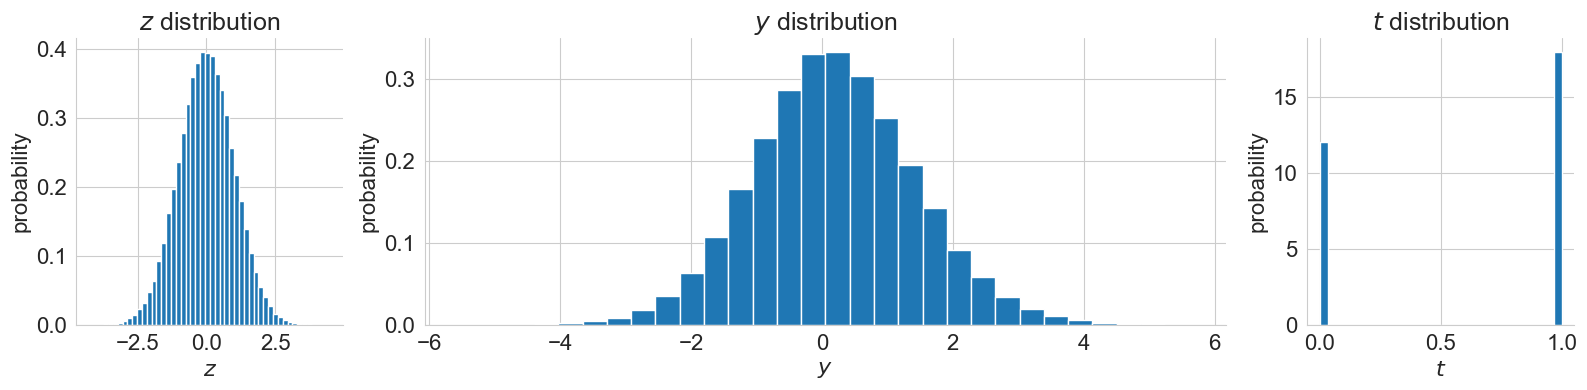

In [5]:
# show distribution of the dataset
fig, ax = plt.subplots(1,3, figsize=(16,4),gridspec_kw={"width_ratios":[1,3,1]})


ax[0].hist(z, bins=50, density=True)
ax[0].set_title("$z$ distribution", fontsize=18)
ax[0].set_xlabel('$z$', fontsize=16)
ax[0].set_ylabel("probability", fontsize=16)
ax[0].tick_params(which='major', axis='both', labelsize=16)

ax[1].hist(y, bins=30, density=True)
ax[1].set_title("$y$ distribution", fontsize=18)
ax[1].set_xlabel('$y$', fontsize=16)
ax[1].set_ylabel("probability", fontsize=16)
ax[1].tick_params(which='major', axis='both', labelsize=16)

ax[2].hist(t, bins=30, density=True)
ax[2].set_title("$t$ distribution", fontsize=18)
ax[2].set_xlabel('$t$', fontsize=16)
ax[2].set_ylabel("probability", fontsize=16)
ax[2].tick_params(which='major', axis='both', labelsize=16)

for i in range(3):
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)

plt.tight_layout()
plt.show()

there are 40095 samles t=0
there are 59905 samles t=1


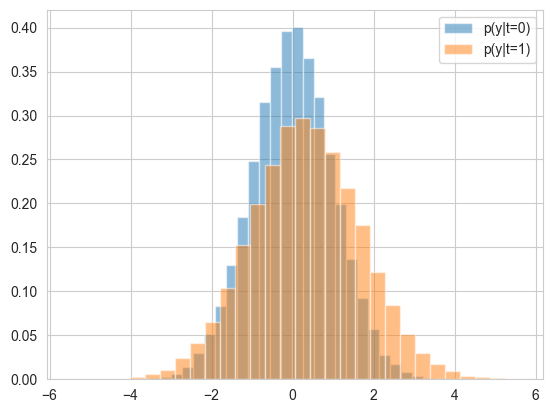

In [6]:
# show distribution of p(y|t)
print(f"there are {len(y_t0)} samles t=0")
print(f"there are {len(y_t1)} samles t=1")
plt.hist(y_t0, bins=30, alpha=0.5, label='p(y|t=0)', density=True)
plt.hist(y_t1, bins=30, alpha=0.5, label='p(y|t=1)', density=True)
plt.legend(loc='upper right')
plt.show()

# Devide the dataset

## Split to two Gaussian

In [49]:
# set the distribution for source domain and the target domain
dist_z_source = [-1, 1]
dist_z_target = [1, 1]

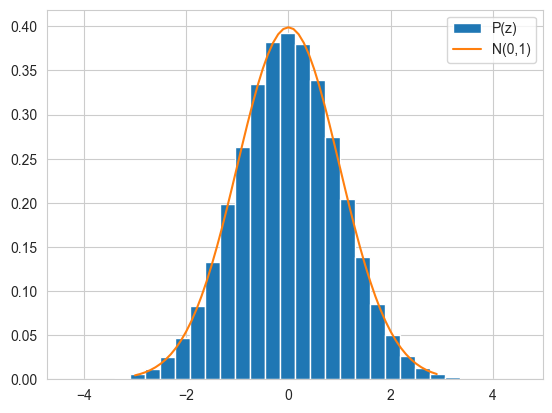

In [50]:


#mu, std = norm.fit(sorted_data['z']) 
x = np.arange(-3, 3, 0.1)
p = norm.pdf(x, loc=0, scale=1)

plt.hist(data['z0'], bins=30, density=True, label='P(z)')
plt.plot(x, p, label='N(0,1)')
plt.legend()
plt.show()

In [51]:

# target z distribution
def p_source(x):
    return norm.pdf(x, loc=dist_z_source[0], scale=dist_z_source[1])

def p_target(x):
    return norm.pdf(x, loc=dist_z_target[0], scale=dist_z_target[1])
    
# z distribution in the dataset
def q(x):
    return norm.pdf(x, loc=0, scale=1)

def rejection_sampling(sample, p, size):
    
    x = np.arange(-3, 3, 0.1)
    k = max(p(x)/q(x))
    c = np.random.uniform(0, 1, size=size)
    mask = p(sample) / (k * q(sample)) > c
    return mask

In [52]:
# rejection sampling
sample = np.array(imageDataset.z[:,0].squeeze())
mask_source = rejection_sampling(sample, p_source, len(data))
source_data = imageDataset.apply_mask(mask_source)

mask_target = rejection_sampling(sample, p_target, len(data))
target_data = imageDataset.apply_mask(mask_target)

there are 8084 samles in source domain
there are 8879 samles in target domain


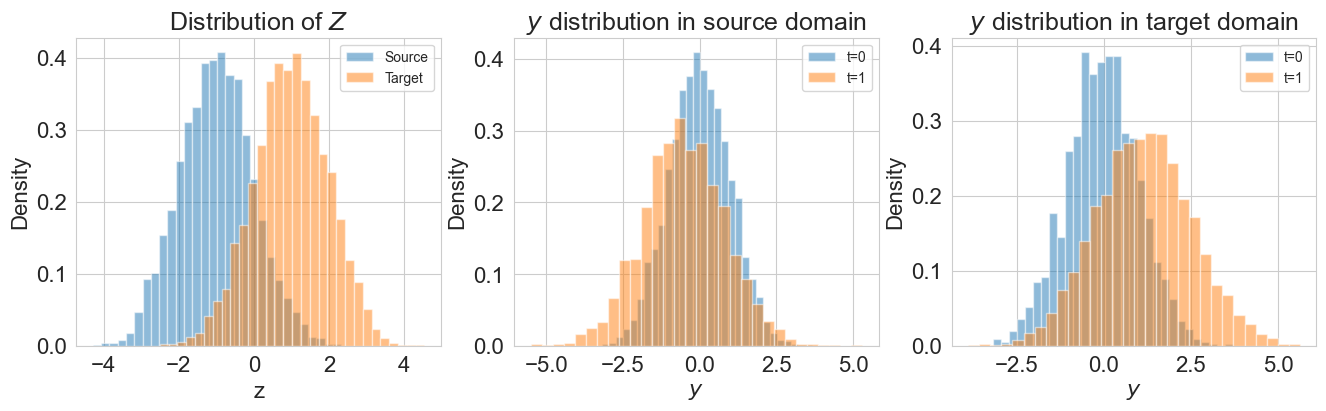

<Figure size 640x480 with 0 Axes>

In [53]:
print(f"there are {len(source_data)} samles in source domain")
print(f"there are {len(target_data)} samles in target domain")

#plt.legend(loc='upper right')
#plt.show()

plot_souce_target(source_data, target_data)

## Cut it by half

In [109]:
sorted_ImageDataset = imageDataset.sort_by_z()

In [110]:
dist_z_source = ["-"]
dist_z_target = ["+"]

length = sorted_ImageDataset.length

if dist_z_source[0] == "-":
    source_data = ImageDataset(sorted_ImageDataset.images[0: int(length/2)], sorted_ImageDataset.X[0: int(length/2)], sorted_ImageDataset.t[0: int(length/2)], sorted_ImageDataset.y[0: int(length/2)], sorted_ImageDataset.z[0: int(length/2)])


    target_data = ImageDataset(sorted_ImageDataset.images[int(length/2):], sorted_ImageDataset.X[int(length/2):], sorted_ImageDataset.t[int(length/2):], sorted_ImageDataset.y[int(length/2):], sorted_ImageDataset.z[int(length/2):])
else:
    target_data = ImageDataset(sorted_ImageDataset.images[0: int(length/2)], sorted_ImageDataset.X[0: int(length/2)], sorted_ImageDataset.t[0: int(length/2)], sorted_ImageDataset.y[0: int(length/2)], sorted_ImageDataset.z[0: int(length/2)])


    source_data = ImageDataset(sorted_ImageDataset.images[int(length/2):], sorted_ImageDataset.X[int(length/2):], sorted_ImageDataset.t[int(length/2):], sorted_ImageDataset.y[int(length/2):], sorted_ImageDataset.z[int(length/2):])

there are 50000 samles in source domain
there are 50000 samles in target domain


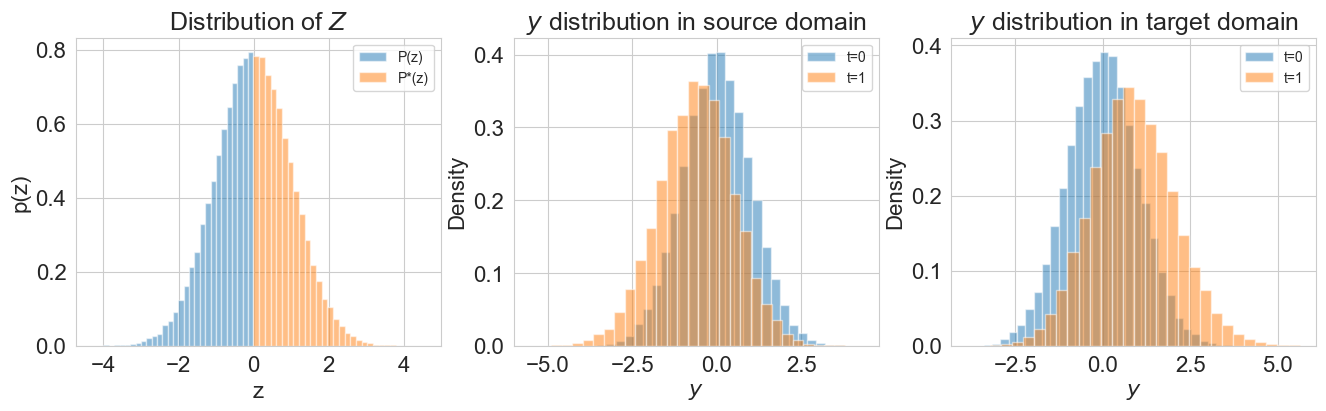

In [111]:
print(f"there are {len(source_data)} samles in source domain")
print(f"there are {len(target_data)} samles in target domain")

#plt.legend(loc='upper right')
#plt.show()

plot_souce_target(source_data, target_data)

## Devide it by digits

# Train on the source domain

In [54]:
import torch.utils
from models import trainZTtoYmodel, trainXTtoYmodel, trainZtoXmodel, GenericDataset, RMSE_loss

number_trained_sample = 1000
source_data = source_data.sample(number_trained_sample)
#target_data = target_data.sample(number_trained_sample)
device = 'mps'
source_dataframe = source_data.dataset_to_dataframe()
target_dataframe = target_data.dataset_to_dataframe()

## Pretrain a decoder for $p(w \vert z)$ and $p(y\vert z, x)$

In [12]:
# can be ignored as we have pretrained decoder for N(-1,1), N(1,1), 
# negative trucated Gaussian and postive trucated Gaussian in 
# model/imagedata
plot_curves=True
device = 'mps'

z_dim = 3
x_dim = 1
param_times = 2

p_y_zt_nn=True
p_y_zt_nn_layers=3
p_y_zt_nn_width=30
p_t_z_nn=False
p_t_z_nn_layers=3
p_t_z_nn_width=30
p_x_z_nn=True
p_x_z_nn_layers=3
p_x_z_nn_width=30

num_epochs = 500
lr_start = 0.001
lr_end = 0.0005
separate_ty = True
BATCH_SIZE = 100

model = ImageCEVAE(x_dim, z_dim, device=device, p_y_zt_nn=p_y_zt_nn, p_y_zt_nn_layers=p_y_zt_nn_layers,
            p_y_zt_nn_width=p_y_zt_nn_width, p_t_z_nn=p_t_z_nn, p_t_z_nn_layers=p_t_z_nn_layers, p_t_z_nn_width=p_t_z_nn_width,
            p_x_z_nn=p_x_z_nn, p_x_z_nn_layers=p_x_z_nn_layers, p_x_z_nn_width=p_x_z_nn_width,separate_ty=separate_ty)
source_dataloader = DataLoader(source_data, batch_size=BATCH_SIZE)



Epoch 0:
Image: 5262.101379394531, x: 19.528533577919006, t: 0, y: 19.46196734905243

Epoch 50:
Image: 1415.2007141113281, x: 18.98470163345337, t: 0, y: 15.275440335273743

Epoch 100:
Image: 932.5657196044922, x: 18.671436309814453, t: 0, y: 14.745296359062195

Epoch 150:
Image: 706.3411712646484, x: 18.249229431152344, t: 0, y: 14.660892605781555

Epoch 200:
Image: 620.1294021606445, x: 17.707452178001404, t: 0, y: 14.610298037528992

Epoch 250:
Image: 565.1984710693359, x: 17.03713846206665, t: 0, y: 14.576022028923035

Epoch 300:
Image: 526.5389671325684, x: 16.225585341453552, t: 0, y: 14.54378616809845

Epoch 350:
Image: 490.6045608520508, x: 15.259230971336365, t: 0, y: 14.509616255760193

Epoch 400:
Image: 466.0627861022949, x: 14.127265334129333, t: 0, y: 14.471090197563171

Epoch 450:
Image: 422.1161117553711, x: 12.826404213905334, t: 0, y: 14.429858326911926



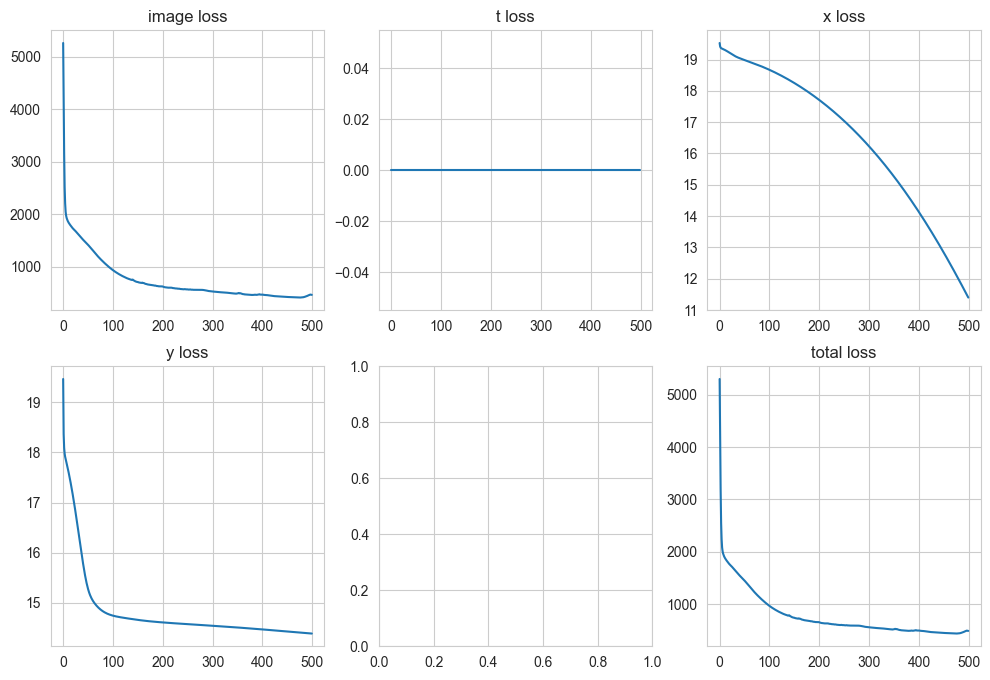

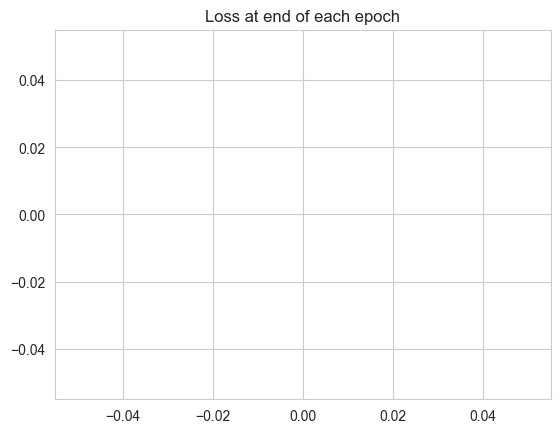

In [13]:
decoder = train_decoder(device, model, True, source_dataloader, num_epochs, lr_start, lr_end)

In [14]:

if p_t_z_nn:
    t_net = 'withTnet'
else:
    t_net = 'withoutTnet'
torch.save(decoder.state_dict(), "./model/{}/{}_NoX_decoder_{}epoches_{}samples_{}".format(main_folder,dist_z_source[0],num_epochs,number_trained_sample, t_net))

## Load a pre-trained decoder

In [55]:
if p_t_z_nn:
    t_net = 'withTnet'
else:
    t_net = 'withoutTnet'
transDe_CEVAE = ImageCEVAE(x_dim, z_dim, device=device, p_y_zt_nn=p_y_zt_nn, p_y_zt_nn_layers=p_y_zt_nn_layers,
            p_y_zt_nn_width=p_y_zt_nn_width, p_t_z_nn=p_t_z_nn, p_t_z_nn_layers=p_t_z_nn_layers, p_t_z_nn_width=p_t_z_nn_width,
            p_x_z_nn=p_x_z_nn, p_x_z_nn_layers=p_x_z_nn_layers, p_x_z_nn_width=p_x_z_nn_width,separate_ty=separate_ty)
print("Loading from " + "./model/{}/{}_X_decoder_{}epoches_{}samples_{}".format(main_folder,dist_z_source[0],num_epochs,number_trained_sample, t_net))

transDe_CEVAE.decoder.load_state_dict(torch.load("./model/{}/{}_X_decoder_{}epoches_{}samples_{}".format(main_folder,dist_z_source[0],num_epochs,number_trained_sample, t_net)))

Loading from ./model/imagedata/-1_X_decoder_500epoches_1000samples_withoutTnet


<All keys matched successfully>

tensor([[1.9330, 0.0408, 1.6731]], device='mps:0')


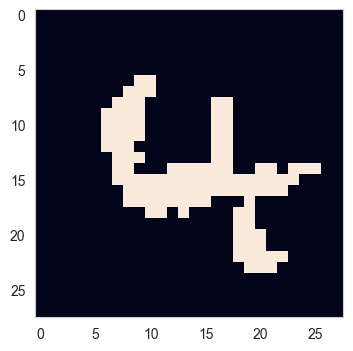

In [16]:


# test the decoder
#Example image from the target data distribution
z = torch.normal(1,1,size=(1,3)).to(device)
print(z)
image,_,_,_,_,_,_ = transDe_CEVAE.decoder(z, t=1)
out = image.squeeze()
fig, ax = plt.subplots(1,1, figsize=(4,4))
plt.imshow(dist.Bernoulli(logits=out).sample().detach().cpu())
plt.grid(False)

## Train a VAE using source domain data

1
Epoch 0:
Image: 4716.683685302734, x: 19.49955379962921, t: 0, y: 19.264492511749268
Epoch loss at epoch 0: 4765.4300537109375
Image: 4716.683685302734, x: 19.49955379962921, t: 0, y: 19.264492511749268



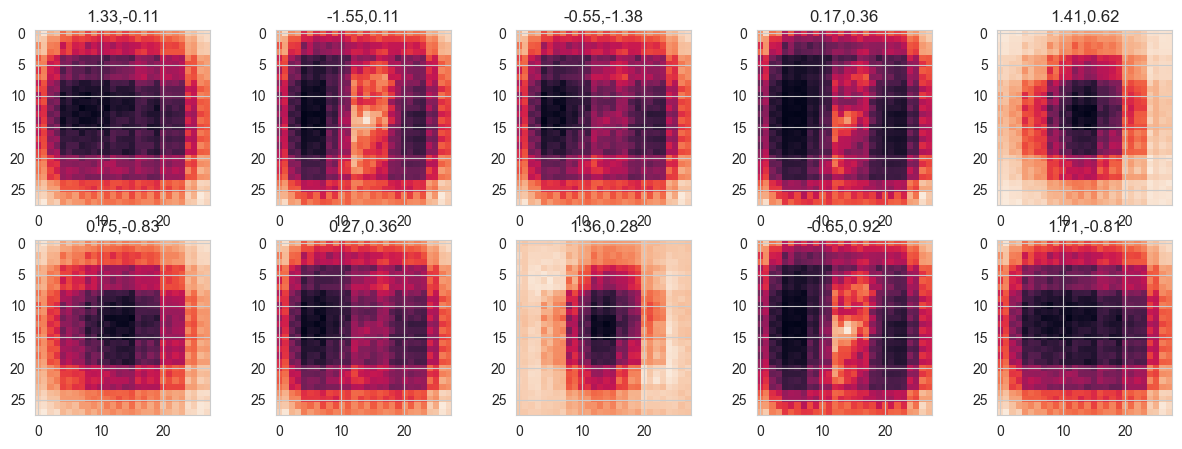

Epoch 20:
Image: 1756.170913696289, x: 17.452929735183716, t: 0, y: 15.31073796749115
Epoch 40:
Image: 1566.501693725586, x: 15.838437557220459, t: 0, y: 15.053199529647827
Epoch loss at epoch 50: 1564.4369049072266
Image: 1452.3118896484375, x: 15.064437627792358, t: 0, y: 14.998063921928406



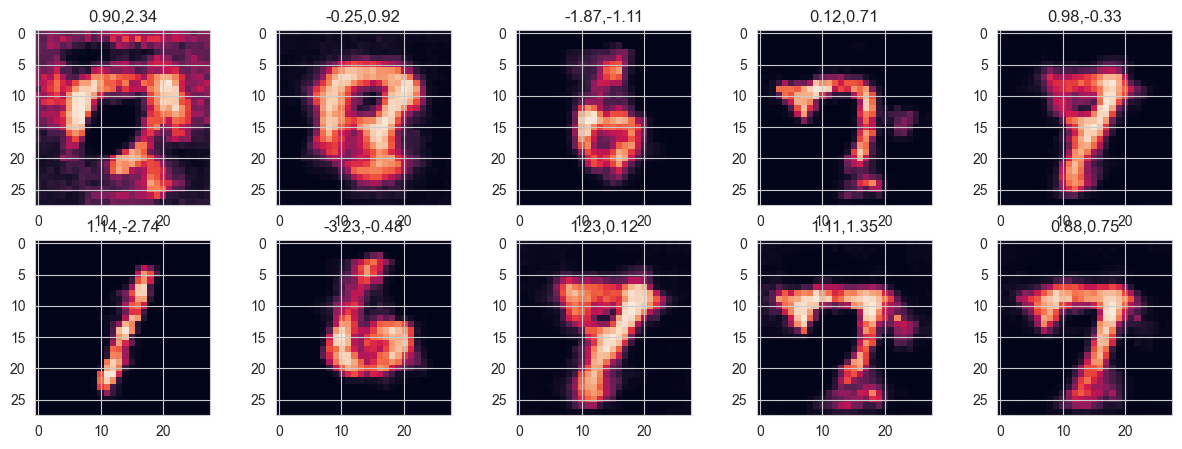

Epoch 60:
Image: 1407.2005996704102, x: 14.30426299571991, t: 0, y: 14.981924176216125
Epoch 80:
Image: 1292.316261291504, x: 12.807417869567871, t: 0, y: 14.887378692626953
Epoch 100:
Image: 1249.5983581542969, x: 11.336641907691956, t: 0, y: 14.82059121131897
Epoch loss at epoch 100: 1371.9647216796875
Image: 1249.5983581542969, x: 11.336641907691956, t: 0, y: 14.82059121131897



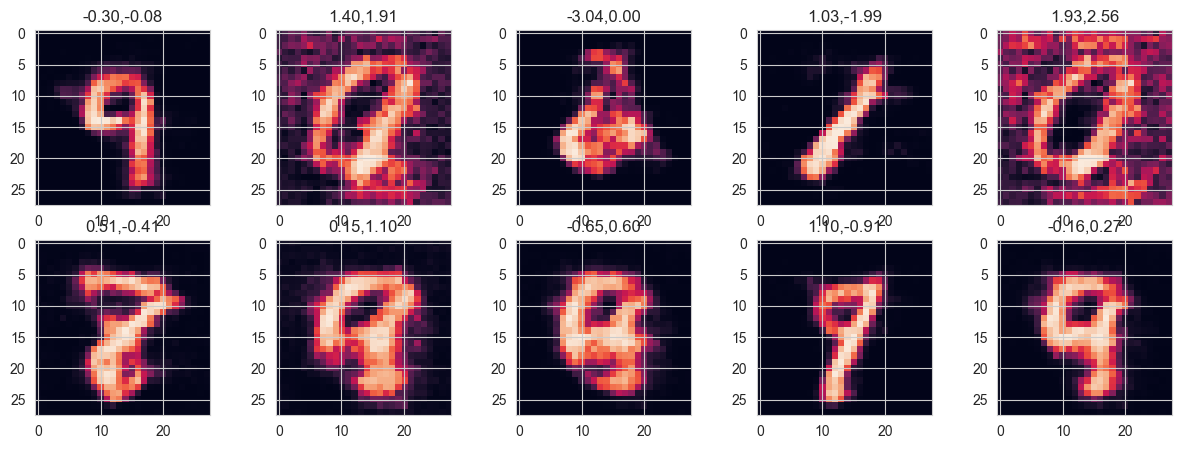

Epoch 120:
Image: 1213.1976623535156, x: 9.92555570602417, t: 0, y: 14.783013105392456
Epoch 140:
Image: 1121.6950073242188, x: 8.545061826705933, t: 0, y: 14.67937695980072
Epoch loss at epoch 150: 1301.880958557129
Image: 1184.684341430664, x: 7.841121792793274, t: 0, y: 14.692275881767273



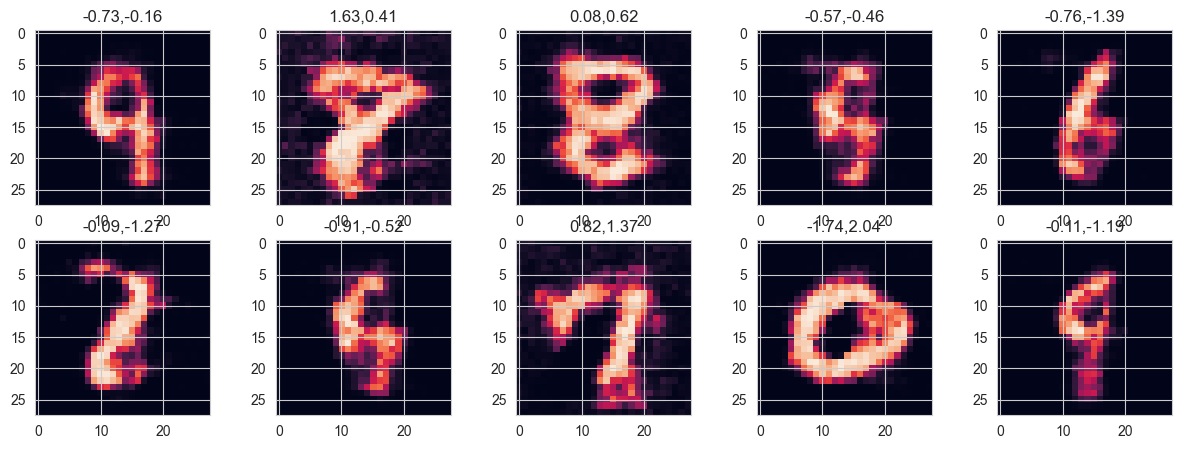

Epoch 160:
Image: 1089.1090774536133, x: 7.151559233665466, t: 0, y: 14.589766025543213
Epoch 180:
Image: 1169.0448608398438, x: 5.872901260852814, t: 0, y: 14.519596576690674
Epoch 200:
Image: 1033.6638793945312, x: 4.552726536989212, t: 0, y: 14.45666754245758
Epoch loss at epoch 200: 1150.0789337158203
Image: 1033.6638793945312, x: 4.552726536989212, t: 0, y: 14.45666754245758



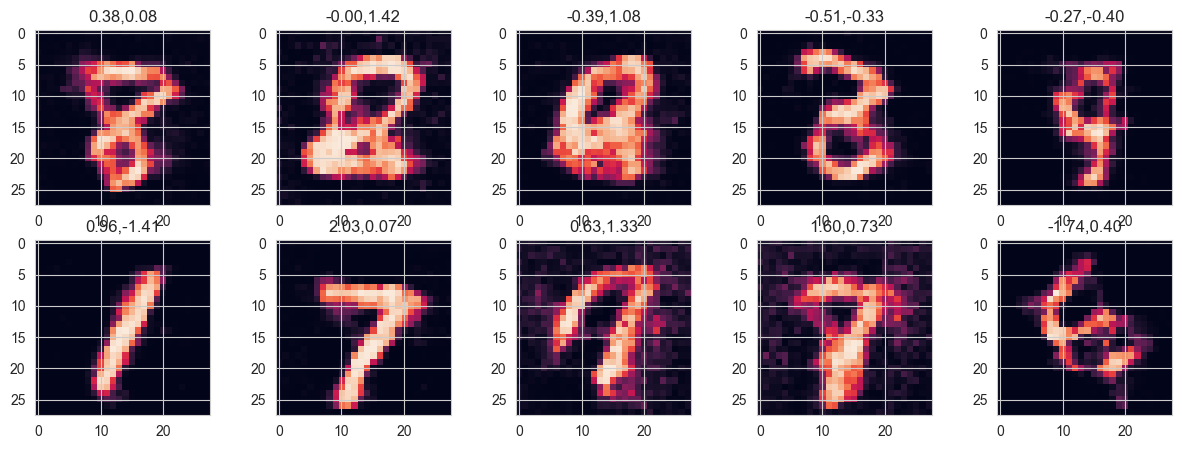

Epoch 220:
Image: 1013.4090118408203, x: 3.2800978124141693, t: 0, y: 14.401973247528076
Epoch 240:
Image: 971.6020584106445, x: 2.0619224905967712, t: 0, y: 14.26071572303772
Epoch loss at epoch 250: 1094.665641784668
Image: 978.1935577392578, x: 1.4423059523105621, t: 0, y: 14.280243515968323



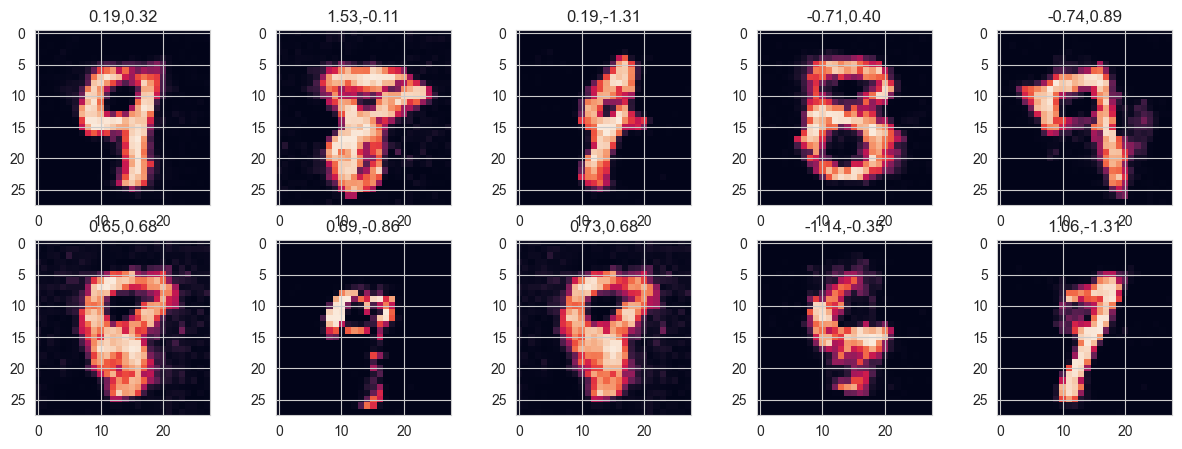

Epoch 260:
Image: 900.7694244384766, x: 0.8566272333264351, t: 0, y: 14.181411027908325
Epoch 280:
Image: 905.3857421875, x: -0.2789800576865673, t: 0, y: 14.126026153564453
Epoch 300:
Image: 925.5479354858398, x: -1.4799694269895554, t: 0, y: 14.214563488960266
Epoch loss at epoch 300: 1037.771957397461
Image: 925.5479354858398, x: -1.4799694269895554, t: 0, y: 14.214563488960266



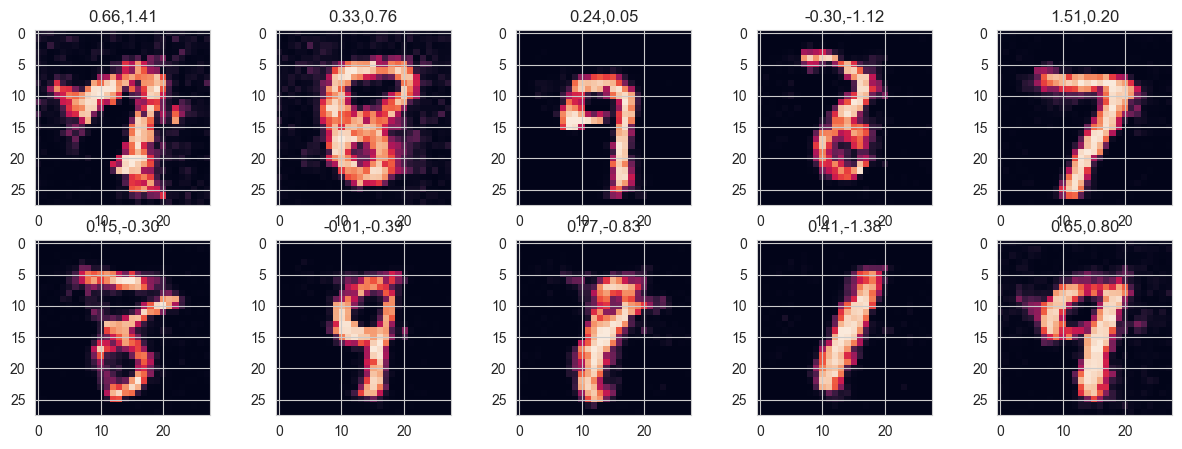

Epoch 320:
Image: 823.5486221313477, x: -2.5692599713802338, t: 0, y: 13.997759461402893
Epoch 340:
Image: 1071.7869415283203, x: -3.652268886566162, t: 0, y: 14.13176965713501
Epoch loss at epoch 350: 933.1306762695312
Image: 820.9145812988281, x: -4.225954532623291, t: 0, y: 14.000043869018555



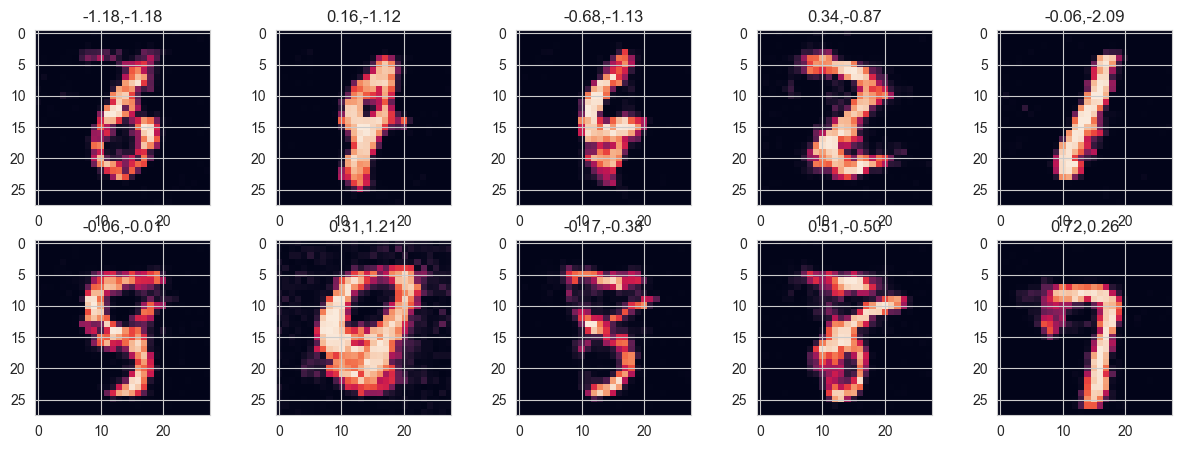

Epoch 360:
Image: 779.077033996582, x: -4.730424582958221, t: 0, y: 13.891936898231506
Epoch 380:
Image: 839.3865127563477, x: -5.752850115299225, t: 0, y: 13.921246647834778
Epoch 400:
Image: 756.6401443481445, x: -6.755788326263428, t: 0, y: 13.818090796470642
Epoch loss at epoch 400: 869.028434753418
Image: 756.6401443481445, x: -6.755788326263428, t: 0, y: 13.818090796470642



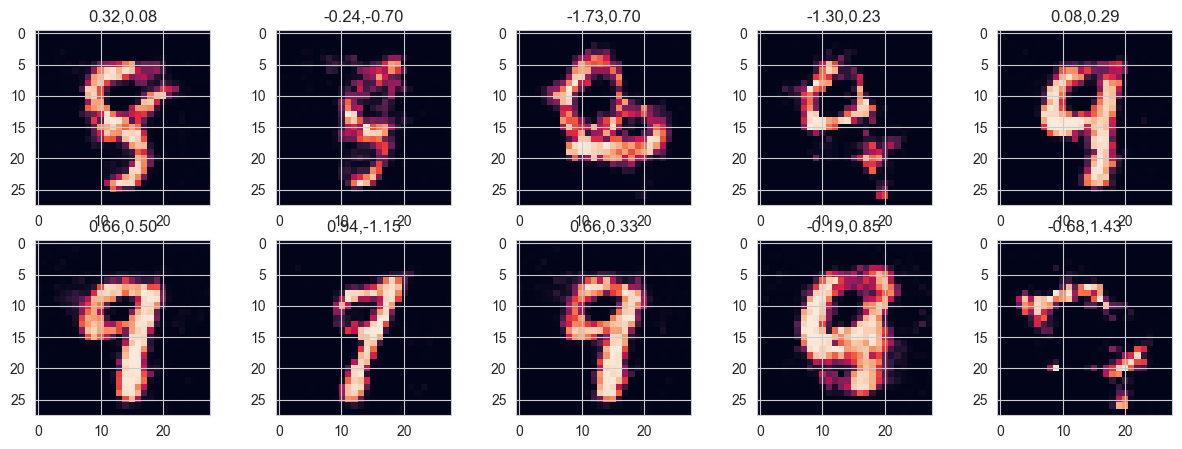

Epoch 420:
Image: 738.0509300231934, x: -7.69605940580368, t: 0, y: 13.831464529037476
Epoch 440:
Image: 736.6894454956055, x: -8.761474788188934, t: 0, y: 13.78146481513977
Epoch loss at epoch 450: 796.8942489624023
Image: 686.0911178588867, x: -9.205161571502686, t: 0, y: 13.770880222320557



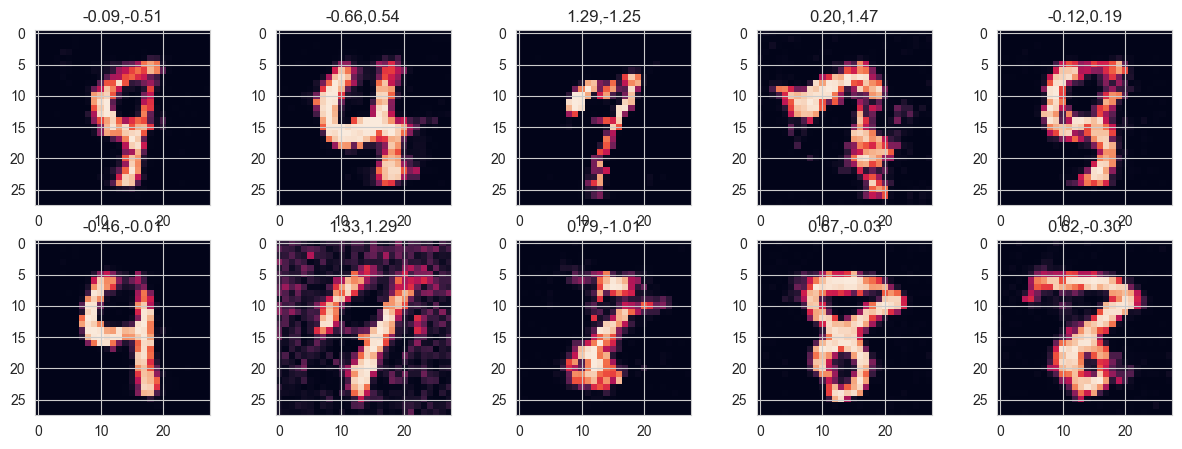

Epoch 460:
Image: 672.105842590332, x: -9.631701231002808, t: 0, y: 13.726381659507751
Epoch 480:
Image: 650.6860656738281, x: -10.469807982444763, t: 0, y: 13.654858708381653


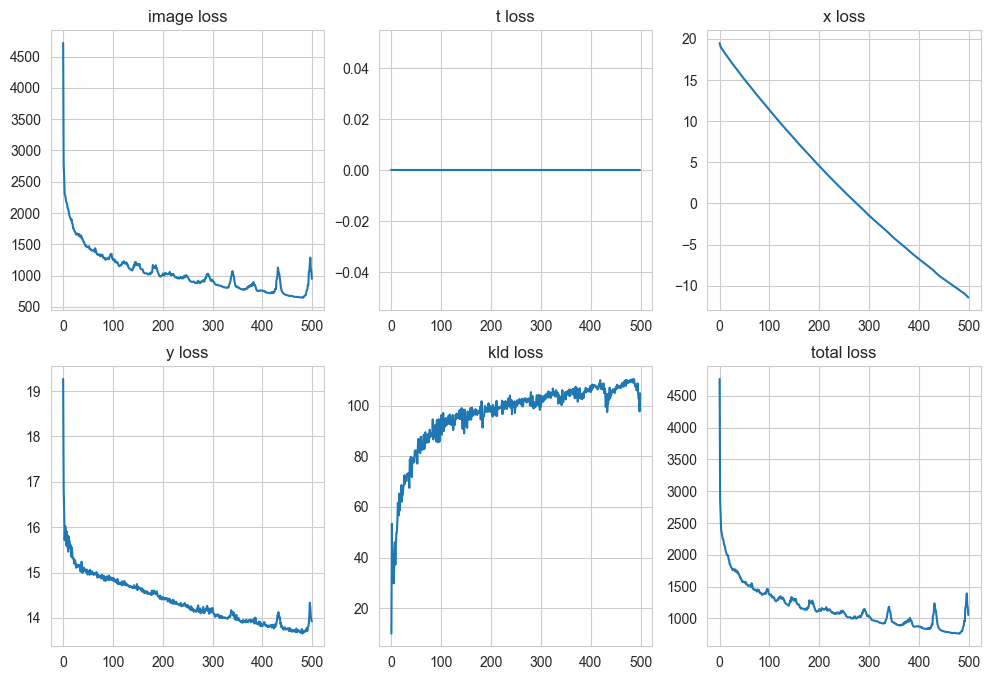

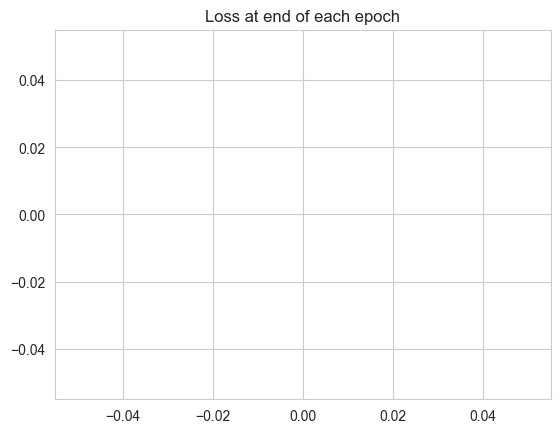

In [25]:
# can be ignored as we have pretrained VAE for N(-1,1), N(1,1), 
# negative trucated Gaussian and postive trucated Gaussian in 
# model/imagedata
source_CEVAE,_ = train_model(device, plot_curves, print_logs=True, train_loader=source_dataloader, num_epochs=num_epochs, lr_start=0.001, lr_end=lr_end, x_dim=x_dim, z_dim=z_dim, p_y_zt_nn=p_y_zt_nn, p_y_zt_nn_layers=p_y_zt_nn_layers, p_y_zt_nn_width=p_y_zt_nn_width, p_t_z_nn=p_t_z_nn, p_t_z_nn_layers=p_t_z_nn_layers, p_t_z_nn_width=p_t_z_nn_width, p_x_z_nn=p_x_z_nn, p_x_z_nn_layers=p_x_z_nn_layers, p_x_z_nn_width=p_x_z_nn_width, loss_scaling=1, separate_ty=separate_ty)

In [26]:
if p_t_z_nn:
    t_net = 'withTnet'
else:
    t_net = 'withoutTnet'
torch.save(source_CEVAE.state_dict(), "./model/{}/{}_NoX_sourceCEVAE_{}epochs_{}samples_{}".format(main_folder,dist_z_source[0],num_epochs,number_trained_sample, t_net))

## Load a pre-trained CEVAE

In [56]:
source_CEVAE = ImageCEVAE(x_dim, z_dim, device=device, p_y_zt_nn=p_y_zt_nn, p_y_zt_nn_layers=p_y_zt_nn_layers,
            p_y_zt_nn_width=p_y_zt_nn_width, p_t_z_nn=p_t_z_nn, p_t_z_nn_layers=p_t_z_nn_layers, p_t_z_nn_width=p_t_z_nn_width,
            p_x_z_nn=p_x_z_nn, p_x_z_nn_layers=p_x_z_nn_layers, p_x_z_nn_width=p_x_z_nn_width,separate_ty=separate_ty)
print("Loading from " + "./model/{}/{}_X_sourceCEVAE_{}epoches_{}samples_{}".format(main_folder,dist_z_source[0],num_epochs,number_trained_sample, t_net))

source_CEVAE.load_state_dict(torch.load("./model/{}/{}_X_sourceCEVAE_{}epochs_{}samples_{}".format(main_folder,dist_z_source[0],num_epochs,number_trained_sample, t_net)))

Loading from ./model/imagedata/-1_X_sourceCEVAE_500epoches_1000samples_withoutTnet


<All keys matched successfully>

tensor([[-0.2362,  0.5533,  1.1840]], device='mps:0')


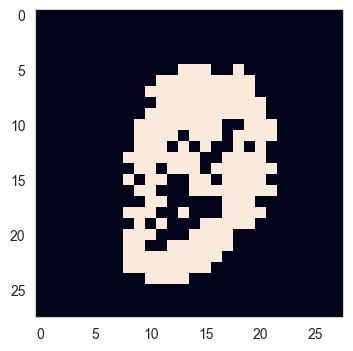

In [120]:

# test the decoder
#Example image from the target data distribution
z = torch.normal(0,1,size=(1,3)).to(device)
print(z)
image,_,_,_,_,_,_ = source_CEVAE.decoder(z, t=1)
out = image.squeeze()
fig, ax = plt.subplots(1,1, figsize=(4,4))
plt.imshow(dist.Bernoulli(logits=out).sample().detach().cpu())
plt.grid(False)

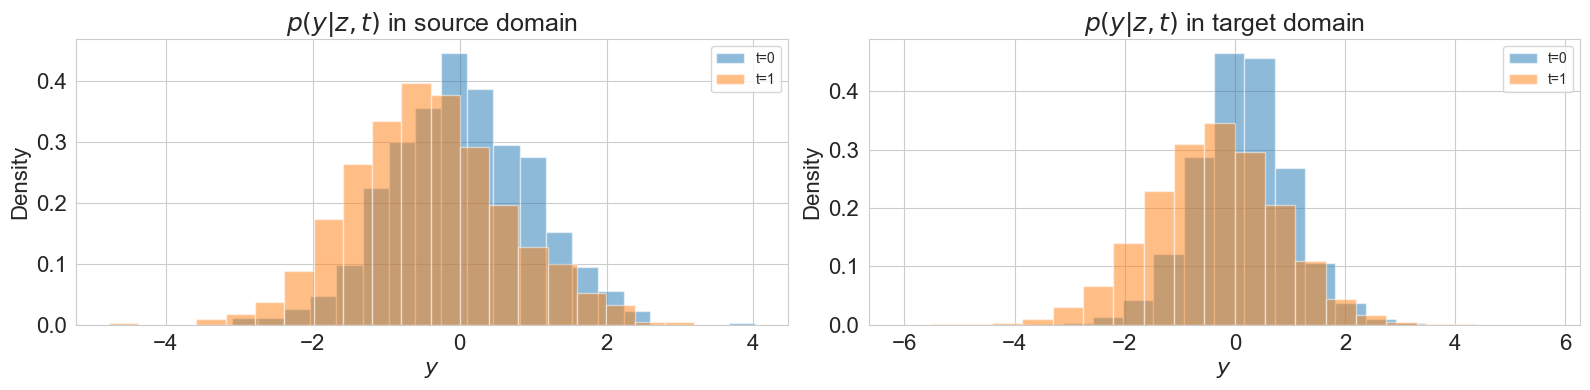

In [121]:
plot_py_zt_image(source_dataframe, target_dataframe, device, source_CEVAE.decoder)

# Test on the target domain dataset

In [57]:

from env import eva_causal_image, eva_random, eva_negative
from copy import deepcopy
import random




seeds = [1,2,3,4,5]

# eliminate the randomness of data sampling
seed = 1
np.random.seed(seed)
random.seed(seed)
N = 1000
#test_data = data.sample(N)        # target domain N(0, 1)
test_data = target_data.sample(N)
test_data.shuffle() #shuffle the data in case of order of the dataset
# Hyperparamer setting
beta = 0.1
vae_freq = [1000, 200, 100, 50, 25, 15, 10, 8, 6, 5]
lr = 0.001
batch_size = 32
y_separate_heads = True
update_decoder = True
train = True

total_regret_vs_vae_freq = {"Causal":[], "VAE":[], "VAE(prior)": [], "Random": [] }

for j in range(len(vae_freq)):
        reward_causal_transDe_episodes = []     
        reward_causal_NoDe_episodes = []
        reward_causal_sourceVAE_episodes = []
        reward_negative_episodes = []
        reward_random_episodes = []

        regret_causal_transDe_episodes = []
        regret_causal_NoDe_episodes = []
        regret_causal_sourceVAE_episodes = []
        regret_negative_episodes = []
        regret_random_episodes = []

        for i in range(len(seeds)):

                seed = seeds[i]
                np.random.seed(seed)
                random.seed(seed)
                torch.manual_seed(seed)
                torch.cuda.manual_seed_all(seed)

                torch.backends.cudnn.deterministic = True
                torch.backends.cudnn.benchmark = False

                target_vae = ImageCEVAE(x_dim, z_dim, device=device, p_y_zt_nn=p_y_zt_nn, p_y_zt_nn_layers=p_y_zt_nn_layers,
            p_y_zt_nn_width=p_y_zt_nn_width, p_t_z_nn=p_t_z_nn, p_t_z_nn_layers=p_t_z_nn_layers, p_t_z_nn_width=p_t_z_nn_width,
            p_x_z_nn=p_x_z_nn, p_x_z_nn_layers=p_x_z_nn_layers, p_x_z_nn_width=p_x_z_nn_width,separate_ty=separate_ty)
                transDe_vae = ImageCEVAE(x_dim, z_dim, device=device, p_y_zt_nn=p_y_zt_nn,              p_y_zt_nn_layers=p_y_zt_nn_layers,
            p_y_zt_nn_width=p_y_zt_nn_width, p_t_z_nn=p_t_z_nn, p_t_z_nn_layers=p_t_z_nn_layers, p_t_z_nn_width=p_t_z_nn_width,
            p_x_z_nn=p_x_z_nn, p_x_z_nn_layers=p_x_z_nn_layers, p_x_z_nn_width=p_x_z_nn_width,separate_ty=separate_ty)
                transDe_vae.decoder = deepcopy(transDe_CEVAE.decoder)
                #transDe_vae.encoder = deepcopy(source_CEVAE.encoder)
                #transDe_vae.decoder = deepcopy(source_CEVAE.decoder)
                source_vae = deepcopy(source_CEVAE)

                reward_causal_transDe, regret_causal_transDe, transVAE_z, true_z = eva_causal_image(device, test_data, transDe_vae, beta=beta, vae_freq=vae_freq[j], lr=lr, batch_size=batch_size, train = train, update_decoder=update_decoder)
                reward_causal_NoDe, regret_causal_NoDe, randomVAE_z, _ = eva_causal_image(device, test_data, target_vae, beta=beta, vae_freq=vae_freq[j], lr=lr, batch_size=batch_size, train=train)
                reward_causal_sourceVAE, regret_causal_sourceVAE, sourceVAE_z, true_z = eva_causal_image(device, test_data, source_vae, beta=beta, vae_freq=vae_freq[j], lr=lr, batch_size=batch_size, train=train)
                reward_random, regret_random = eva_random(test_data, N) 

                reward_causal_transDe_episodes.append(reward_causal_transDe)
                reward_causal_NoDe_episodes.append(reward_causal_NoDe)
                reward_causal_sourceVAE_episodes.append(reward_causal_sourceVAE)
                reward_random_episodes.append(reward_random)

                regret_causal_transDe_episodes.append(regret_causal_transDe)
                regret_causal_NoDe_episodes.append(regret_causal_NoDe)
                regret_causal_sourceVAE_episodes.append(regret_causal_sourceVAE)
                regret_random_episodes.append(regret_random) 
        print("Test done for vae frequency ", vae_freq[j])
        total_regret_vs_vae_freq["Causal"].append(np.mean(np.array([regret_causal_transDe_episodes[i][-1] for i in range(len(seeds))])))  
        total_regret_vs_vae_freq["VAE"].append(np.mean(np.array([regret_causal_NoDe_episodes[i][-1] for i in range(len(seeds))])))
        total_regret_vs_vae_freq["VAE(prior)"].append(np.mean(np.array([regret_causal_sourceVAE_episodes[i][-1] for i in range(len(seeds))])))     
        total_regret_vs_vae_freq["Random"].append(np.mean(np.array([regret_random_episodes[i][-1] for i in range(len(seeds))])))


Test done for vae frequency  1000
Test done for vae frequency  200
Test done for vae frequency  100
Test done for vae frequency  50
Test done for vae frequency  25
Test done for vae frequency  15
Test done for vae frequency  10
Test done for vae frequency  8
Test done for vae frequency  6
Test done for vae frequency  5


In [130]:
# store the results in csv file
# data structure:
# tranDe,randomVAE,sourceVAE,random, gradient step
# x1,x2,x3,x4,x5
# x1,x2,x3,x4,x5
# x1,x2,x3,x4,x6
import csv

num_update = [int(1000/freq) for freq in vae_freq]
name = "MNIST_total_regret_"+str(dist_z_source[0])+"_"+str(dist_z_target[0])+".csv"
print(name)
# Open a CSV file for writing

keys = list(total_regret_vs_vae_freq.keys())
keys.append('gradient_steps')

# Open a CSV file for writing
with open("results/"+name, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the header (keys of the dictionary)
    writer.writerow(keys)

    # Write the rows (zip the ndarray values to create rows)
    rows = zip(*total_regret_vs_vae_freq.values(), num_update)
    for row in rows:
        writer.writerow(row)

keys =['posterior_z', 'true_z']


with open('results/'+name, 'w', newline='') as file:
    writer = csv.writer(file)

    writer.writerow(keys)

    rows = zip(transVAE_z, true_z)
    for row in rows:
        writer.writerow(row)

total_regret_-_+.csv


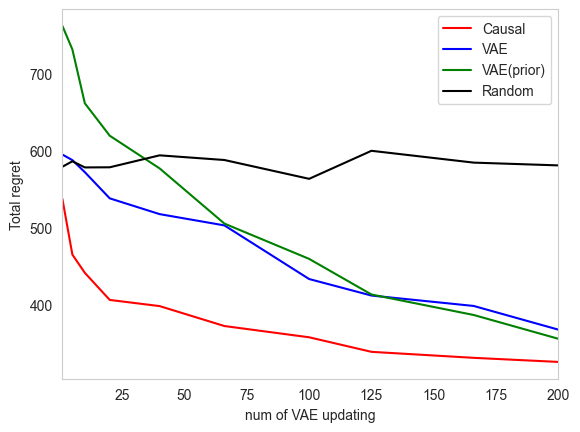

In [58]:
# ploting the regret
from plot_functions import plot_regret, plot_total_regret_vs_freq

#plot_regret(regret_causal_transDe_episodes, regret_causal_NoDe_episodes, regret_causal_sourceVAE_episodes, regret_negative_episodes, regret_random_episodes, dist_z_source=dist_z_source, dist_z_target=dist_z_target)
color_list = ['red', 'blue', 'green', 'black']
num_update = [int(1000/freq) for freq in vae_freq]
plot_total_regret_vs_freq(total_regret_vs_vae_freq, num_update, color_list)

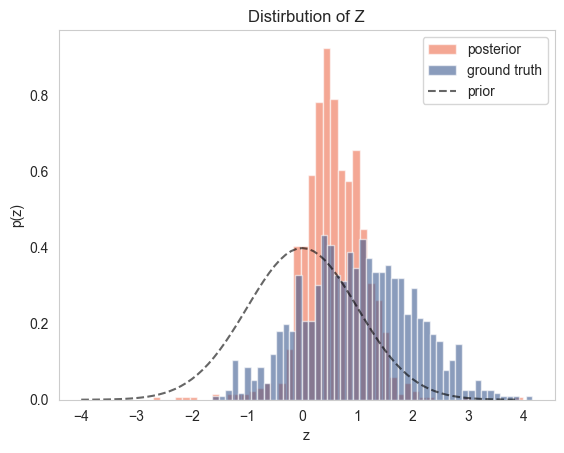

In [59]:
z = np.random.randn(1000)
z = [transVAE_z, true_z]
labels = ['posterior', 'ground truth']
name = "MNIST_dist_z_"+str(dist_z_source[0])+"_"+str(dist_z_target[0])+".tex"
plot_z_comparasion(z, labels, name, z_index=0)